In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats


def set_font_size(ax, font_size, legend_font_size=None):
    """Set fontsize of all axis text objects to specified value."""

    texts = ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels())

    for text in texts:
        text.set_fontsize(font_size)

    if legend_font_size is None:
        legend_font_size = font_size

    legend = ax.get_legend()

    if legend:
        for text in legend.get_texts():
            text.set_fontsize(legend_font_size)

In [2]:
# define base item vectors (level-0 compositions)
def test_braid_func(b, in_type, n_s, smty_fn, params=None):
    fig, axs = plt.subplots(3, 1, figsize=(12, 9), tight_layout=True)
    
    s = np.linspace(-1, 1, n_s)
    
    if in_type.lower() == 'sq_exp':
        f_x_1 = np.exp(-(s**2)/(2*.2**2))
        f_x_0 = np.roll(f_x_1, -int(np.round(n_s/3)))
        f_x_2 = np.roll(f_x_1, int(np.round(n_s/3)))
    elif in_type.lower() == 'unif':
        f_x_0 = np.random.rand(len(s))
        f_x_1 = np.random.rand(len(s))
        f_x_2 = np.random.rand(len(s))
    elif in_type.lower() == 'exp':
        f_x_0 = np.random.exponential(1, len(s))
        f_x_1 = np.random.exponential(1, len(s))
        f_x_2 = np.random.exponential(1, len(s))
    elif in_type.lower() == 'rank':
        f_x_0 = np.arange(n_s)[np.random.permutation(n_s)]
        f_x_1 = np.arange(n_s)[np.random.permutation(n_s)]
        f_x_2 = np.arange(n_s)[np.random.permutation(n_s)]
    elif in_type.lower() == 'rand_int':
        f_x_0 = np.random.randint(0, params['max_rand_int'], n_s)
        f_x_1 = np.random.randint(0, params['max_rand_int'], n_s)
        f_x_2 = np.random.randint(0, params['max_rand_int'], n_s)
        
    # plot base item vectors
    axs[0].plot(s, f_x_0, c='r', lw=4)
    axs[0].plot(s, f_x_1, c='y', lw=4)
    axs[0].plot(s, f_x_2, c='b', lw=4)
    
    axs[0].set_title('X')
    axs[0].legend(['x_0', 'x_1', 'x_2'], loc=9, ncol=3)
    
    # construct level-1 compositions (pairings)
    f_y_0 = b(f_x_1, f_x_2)
    f_y_1 = b(f_x_0, f_x_2)
    f_y_2 = b(f_x_0, f_x_1)
    
    # plot level-one compositions
    axs[1].plot(s, f_y_0, c='r', lw=4)
    axs[1].plot(s, f_y_1, c='y', lw=4)
    axs[1].plot(s, f_y_2, c='b', lw=4)
    
    axs[1].set_title('Y')
    axs[1].legend(['y_0', 'y_1', 'y_2'], loc=9, ncol=3)
    
    # construct level-2 compositions
    f_z_0 = b(f_x_0, f_y_0)
    f_z_1 = b(f_x_1, f_y_1)
    f_z_2 = b(f_x_2, f_y_2)
    
    axs[2].plot(s, f_z_0, c='r', lw=4)
    axs[2].plot(s, f_z_1, c='y', lw=4)
    axs[2].plot(s, f_z_2, c='b', lw=4)
    
    axs[2].set_title('Z')
    axs[2].legend(['z_0', 'z_1', 'z_2'], loc=9, ncol=3)
    
    for ax in axs:
        ax.set_xlim(-1, 1)
        ax.set_xlabel('Neuron')
        ax.set_ylabel('Activity')
        set_font_size(ax, 16)
        
    # check for successful compositionality
    fig, ax = plt.subplots(1, 1, figsize=(12, 8), tight_layout=True)
    size = 300
    
    x_tick_labels = ['x_0', 'x_1', 'x_2', 'y_0', 'y_1', 'y_2', 'z_0', 'z_1', 'z_2']
    y_tick_labels = ['z_2', 'z_1', 'z_0', 'y_2', 'y_1', 'y_0']
    
    if smty_fn == 'dot':
        smty_fn = np.dot
    elif smty_fn == 'l2':
        smty_fn = lambda x, y: np.exp(-np.linalg.norm((x - y)**2))
    elif smty_fn == 'match':
        smty_fn = lambda x, y: np.mean(x == y)
    elif smty_fn == 'match_exp':
        smty_fn = lambda x, y: np.exp(10*np.mean(x == y))
        
    ## plot truth
    for y_ctr in range(6):
        ax.axhline(y_ctr, color='gray', alpha=.4)
        ax.axhline(y_ctr + .5, color='gray', alpha=.4, ls='--')
        ax.scatter(range(9), y_ctr*np.ones(9), s=size/2, facecolors='w', edgecolors='k')

    ax.scatter([1, 2], [5, 5], c='k', s=size)  # y_0
    ax.scatter([0, 2], [4, 4], c='k', s=size)  # y_1
    ax.scatter([0, 1], [3, 3], c='k', s=size)  # y_2

    ax.scatter([0, 3], [2, 2], c='k', s=size)  # z_0
    ax.scatter([1, 4], [1, 1], c='k', s=size)  # z_1
    ax.scatter([2, 5], [0, 0], c='k', s=size)  # z_2

    ## compute and plot similarities
    all_fs = [f_x_0, f_x_1, f_x_2, f_y_0, f_y_1, f_y_2, f_z_0, f_z_1, f_z_2]

    for y_ctr, f_i in enumerate([f_z_2, f_z_1, f_z_0, f_y_2, f_y_1, f_y_0]):

        x_smty = -.5 + .5 * np.arange(19)
        smty = np.zeros(19)  # store similarity vals interleaved with zeros for cleaner plotting

        for x_ctr, f_j in enumerate(all_fs):
            idx = 2*x_ctr + 1  # idx to store f_i, f_j similarity
            smty[idx] = smty_fn(f_i, f_j)

        # set self similarity to nan
        smty[-2*(y_ctr+1)] = np.nan

        # normalize similarities to max
        smty *= (.5 / np.nanmax(smty))

        # plot
        ax.plot(x_smty, y_ctr + smty, lw=3, c='k')

    ax.set_xlim(-1, 9)
    ax.set_ylim(-1, 6)

    ax.set_xticks(range(9))
    ax.set_yticks(range(6))

    ax.set_xticklabels(x_tick_labels)
    ax.set_yticklabels(y_tick_labels)

    ax.set_title('Similarity')

    set_font_size(ax, 16)

/home/melete/miniconda3/envs/py3/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


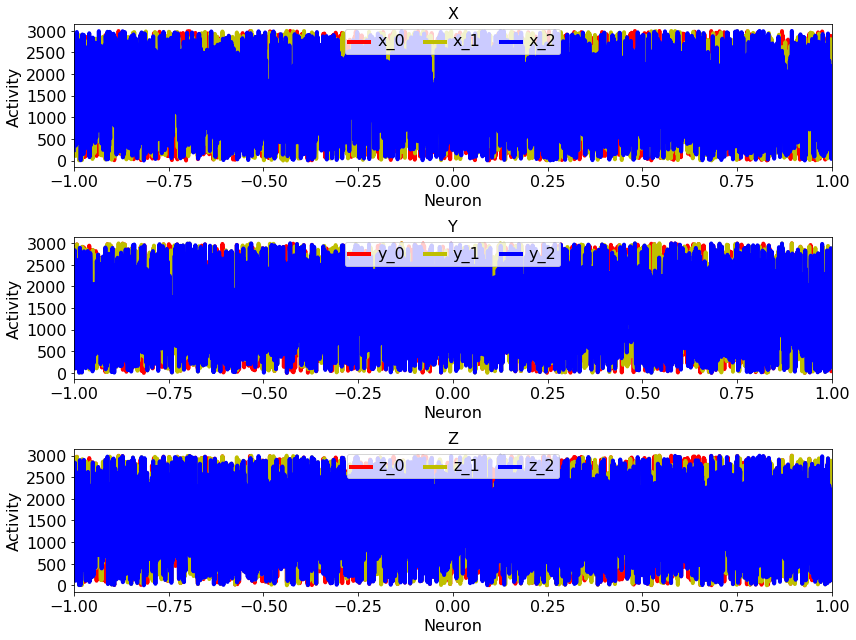

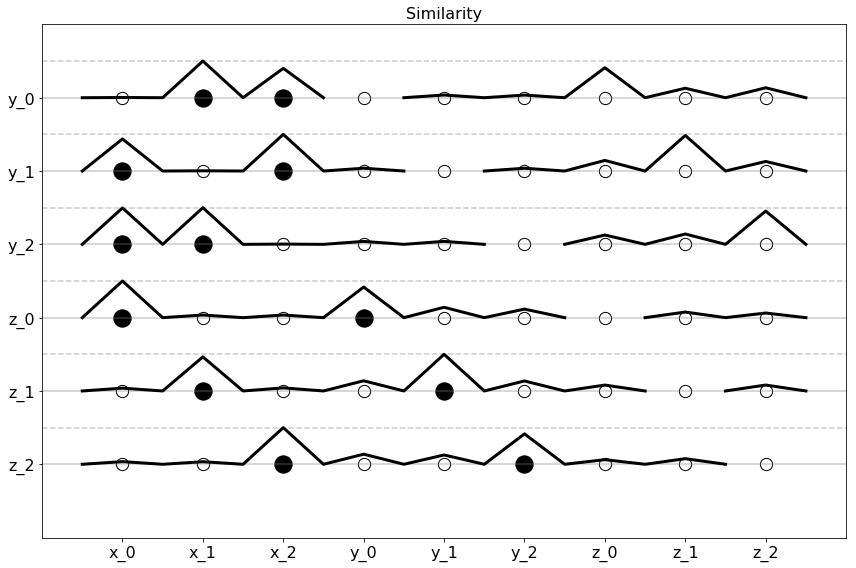

In [3]:
np.random.seed(None)

def b_0(f_i, f_j):
    
    seed = int(np.round(f_i.dot(f_j))) % 10000
    np.random.seed(seed)
    mask = np.random.rand(len(f_i)) > 0.5
    tmp = f_i.copy()
    tmp[mask] = f_j[mask]
    
    return tmp

test_braid_func(b_0, in_type='rank', n_s=3000, smty_fn='match_exp')

/home/melete/miniconda3/envs/py3/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


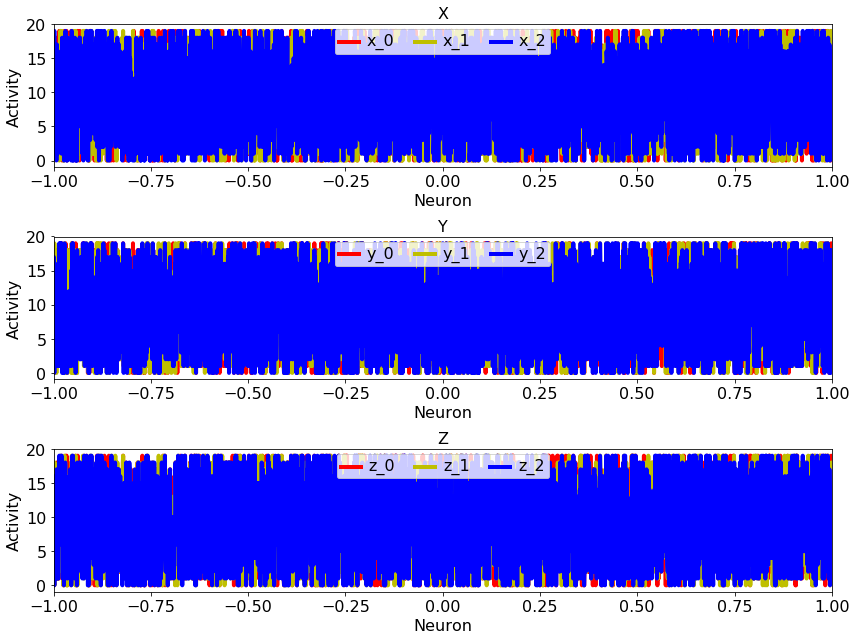

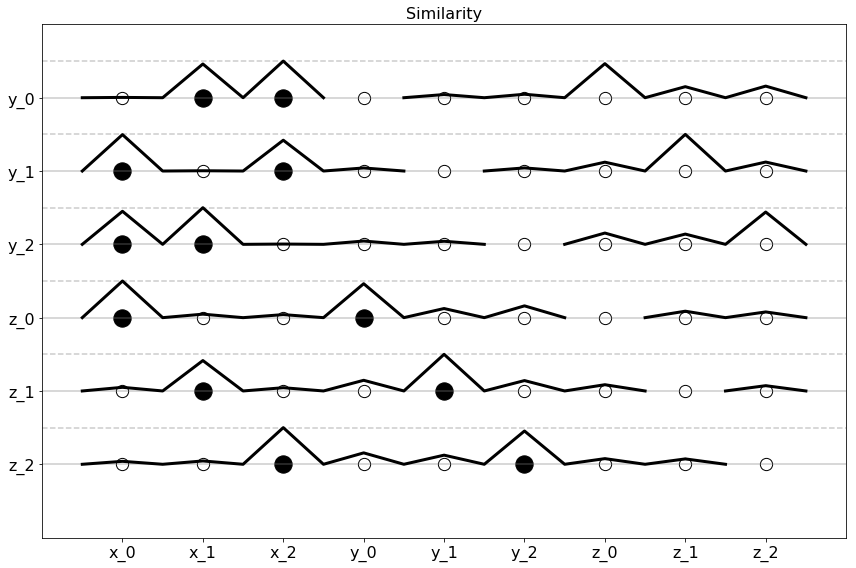

In [12]:
np.random.seed(None)

def b_0(f_i, f_j):
    
    seed = int(np.round(f_i.dot(f_j))) % 10000
    np.random.seed(seed)
    mask = np.random.rand(len(f_i)) > 0.5
    tmp = f_i.copy()
    tmp[mask] = f_j[mask]
    
    return tmp

test_braid_func(b_0, in_type='rand_int', n_s=3000, smty_fn='match_exp', params={'max_rand_int': 20})